In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [2]:
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
from itertools import permutations
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

### Data preparation and visualization

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [6]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

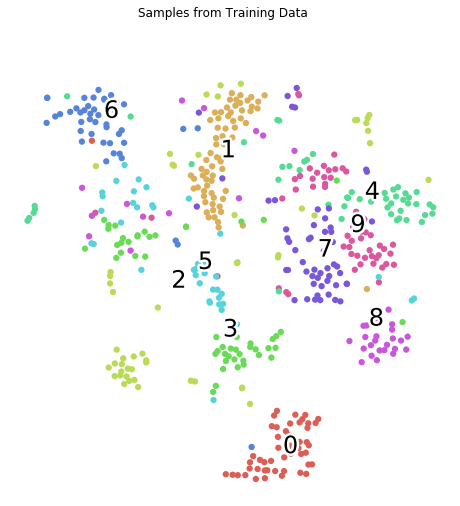

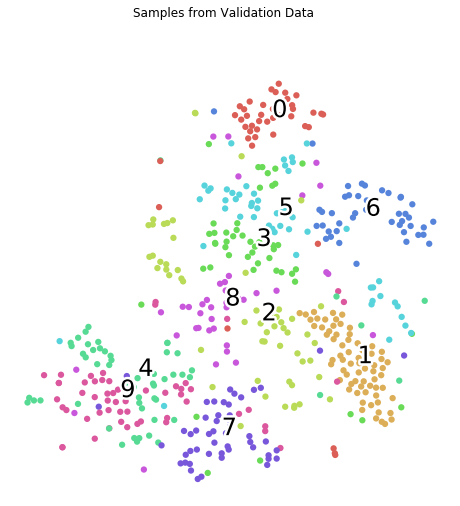

In [7]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

#### Generating Triplets

In [11]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [12]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

In [13]:
X_train.shape, X_test.shape

((180000, 3, 784), (45000, 3, 784))

### Triplet Loss

In [14]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    print('y_pred.shape = ',y_pred)
    
    total_length = y_pred.shape.as_list()[-1]
    
    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

    # distance between the anchor and the positive
    positive_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    negative_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = positive_dist-negative_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

### Building architecture

#### base network

In [15]:
def create_base_network(in_dims):
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    
    return model

In [18]:
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            876036      anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [20]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [21]:
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [46]:
Anchor_train = X_train[:,0,:].reshape(-1,28,28,1)
Positive_train = X_train[:,1,:].reshape(-1,28,28,1)
Negative_train = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor_train.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

In [47]:
print(Anchor_train.shape)
print(Y_dummy.shape)

(180000, 28, 28, 1)
(180000, 300)


In [44]:
#model.fit([Anchor_train,Positive_train,Negative_train],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=64, epochs=100)